## ResNet
탄생배경<br>
>model layer를 깊게 쌓을수록 성능이 증가, 하지만 gradient vanishing/exploding 문제가 발생하므로 특정 depth 이상 넘어갈수록 model의 성능이 급격히 하락. 이를 해결할 방안 존재? <br>

해결 idea <br>
>layer를 쌓을 때 적어도 그 전 layer의 성능보다 낮아지지 않도록 하는 방법 고안 <br>

방법론 <br>
> 새로운 layer를 쌓을 때, 새로운 layer의 output과 이전 layer의 output의 결과값을 더한다. <br>

> 근거: 만약 해당 layer의 depth가 최적일 경우 역전파(backpropagation)에 의해 새로운 layer의 output이 0에 수렴할 것이므로 model의 성능이 떨어지지 않음. <br>

ref) With the residual learning reformulation, if identity mappings are optimal, the solvers
may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings. (paper page 3)

```python
# psudo code
class residual_connection(nn.Module):
  def __init__(self):
    self.block_1 = nn.Sequential()
    self.block_2 = nn.sequential()
    ...

  def forward(self, x):
    identity = x
    x = self.block_1(x)
    x += identity # 만약 layer가 무리하게 쌓아졌다고 network가 판단할 경우 x -> 0 (by backpropagation)

```
paper: https://arxiv.org/abs/1512.03385?context=cs <br>
ref(how to make ResNet with PyTorch, youtuber: Aladdin Persson): <br>
https://www.youtube.com/watch?v=DkNIBBBvcPs&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=19 <br> 


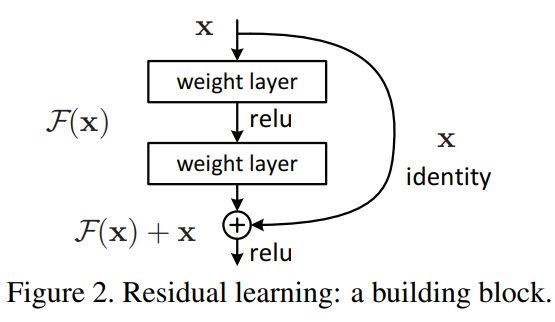

In [ ]:
# residual connection(skip connection) from ResNet paper figure 2.
display.Image(os.path.join(os.getcwd(), 'pic/residual_learning.png'))

In [ ]:
from google.colab import drive
import os
import sys
from IPython import display
drive.mount('/content/drive')

FOLDERNAME = 'models_from_scratch'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/models_from_scratch


## ResNet Architecture
ResNet은 VGG Network와 비슷하게 version(layer depth)에 따라 각 block의 depth가 변합니다.  <br>
또한 Conv net block 안에서 output size는 변하지 않고 pool을 통해서 size의 크기(H, W)를 각각 반으로 줄이게 됩니다. <br>
cf) table 1.에는 각각의 conv block 후에 max pool 표기를 생략되었습니다. <br>(kernel: 2, stride: 2) <br>


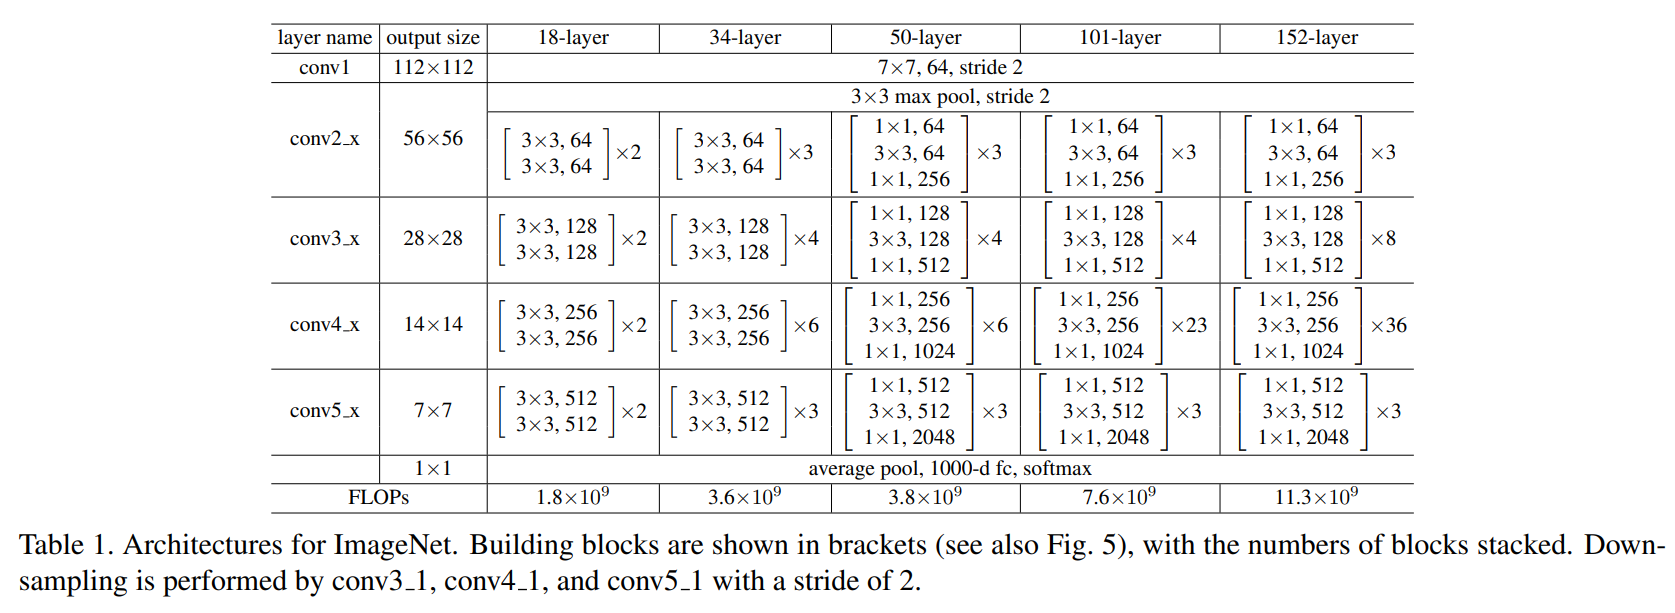

In [ ]:
# ResNet architecture from ResNet paper table 1.
display.Image(os.path.join(os.getcwd(), 'pic/ResNet_architecture.png'))

## residual block
residual block을 통해 각 layer의 input과 output을 더한다는 것은 이해가 되지만 실질적인 연산에 대해서는 의문이 드실 것입니다. <br>
예를 들어 ResNet(18-layer)의 conv2_x block과 conv3_x block을 살펴보면
```python
# psudo code
class conv2_x(nn.Module):
  def __init__(self):
    conv2_x = nn.Sequential(conv(),
                          conv())

  def forward(self, x):
    '''
      x(Tensor[N, 64, 56, 56]
    '''
    identity = x
    x = conv2_x(x) # [N, 64, 56, 56]
    x += identity 
  
x = nn.MaxPool2d(conv2_x(x) * depth(2)) # [N, 64, 56, 56] -> [N, 64, 28, 28]

class conv3_x(nn.Module):
  def __init__(self):
    conv3_x = nn.Sequential(conv(),
                            conv())

  def forward(self, x):
    '''
    conv2_x & max pool의 output(x+identity)이 conv3_x block의 input으로 구성되는 경우라고 생각할 때,
    x + identity(Tensor[N, 64, 28, 28])
    '''
    identity = x
    x = conv3_x(x)
    x += identity # <- !Error 
    # x(Tensor[N, 128, 28, 28]), identity(Tensor[N, 64, 28, 28])
```
즉, 같은 conv block내에서 residual block은 channel이 변하지 않기 때문에 문제가 발생하지 않지만 다음 conv block으로 진입할 때 in channel과 out channel이 다르기 때문에 연산이 되지 않습니다. <br>
그러면 이러한 channel 불균형을 어떻게 해결해야 할까요? <br>
저자는 크게 2가지 방법을 제시합니다. <br>
> 1) zero padding <br>
> 2) 1x1 conv 사용 (channel 변환) <br>

(ref: paepr 6page, subtitle: Identity vs. Projection Shortcuts.) <br>

저희는 2) 1x1 conv을 사용하여 channel 확장을 통해 해당 문제를 해결하여 residual block을 만들어 보겠습니다. <br>

```python
# psudo code
class residual_block(nn.Module):
  def __init__(self):
    super(residual_block, self)__init__():
    
    self.block = nn.Sequential()

    self.projection = nn.Conv2d(in_channels = prev layer out channels,
                                out_channels = this layer channels,
                                kernel_size = (1, 1)
                                stride = 1)

  def forward(self, x):
    identity = x
    x = self.block(x)
    # 조건문으로 작성해보세요!
    try: 
      x += identity
    except:
      identity = self.projection(identity)
      x += identity

    return x
```

저희는 모든 ResNet model을 설계하진 않고 50, 101, 152 version만 설계하겠습니다. <br>
아래 표를 보시면 (50, 101, 152)버전의 모든 conv block은 (1x1, 3x3, 1x1)의 구조로 이루어졌습니다. <br>
block 내에서 out_channel, block 갯수만 다르다는 것을 아실 수 있습니다. <br>
따라서 residual block을 통해서 (1x1, 3x3, 1x1) conv block을 만들고 반복문을 통해 다시 block을 만들어주면 간단하게 모델을 만들 수 있을 것 같습니다. <br>

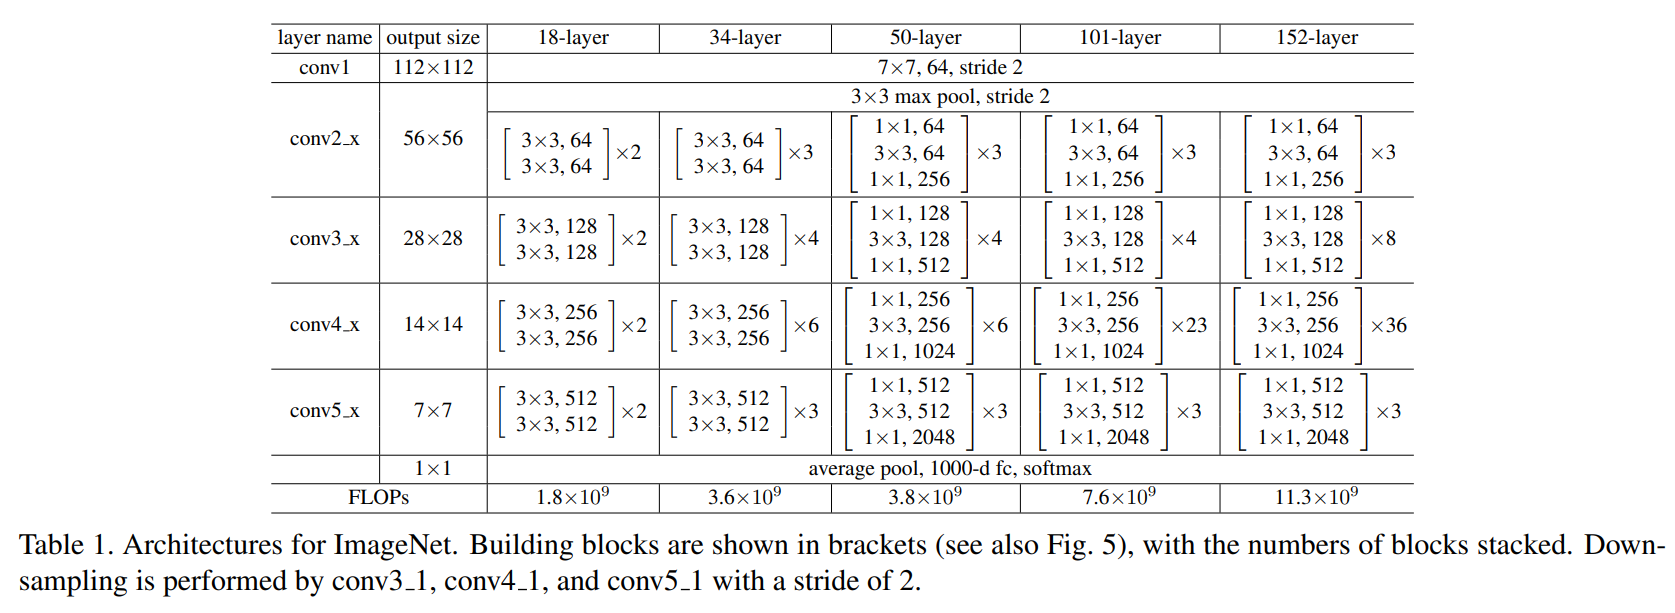

In [ ]:
# ResNet architecture from ResNet paper table 1.
display.Image(os.path.join(os.getcwd(), 'pic/ResNet_architecture.png'))

```python
# psudo code
class residual_block(nn.Module):
  def __init__(self):
    self.block = nn.Sequential(nn.Conv2d(in_channels,
                                        out_channels,
                                        kernel_size = (1, 1),
                                        stride = 1),
                               nn.Conv2d(in_channels,
                                        out_channels,
                                        kernel_size = (3, 3),
                                        stride = 1,
                                        padding = 1),
                               nn.Conv2d(in_channels,
                                        out_channels,
                                        kernel_size = (1, 1),
                                        stride = 1))
    self.projection
    
  def forward(self, x):
    return residual connection

class ResNet(nn.Module):
  def __init__(self):
    # version check

    self.conv1
    self.conv2 = [residual_block]
    for _ in range(num_repeats of conv2 block - 1):
      self.conv2.append(residual_block)
    self.conv2.append(nn.MaxPool2d())
    self.conv2 = nn.Sequential(*self.conv2)

    ...

    self.classifier = nn.Sequential(nn.AvgPool2d(),
                                    nn.Flatten(),
                                    Linear(out_features = num_classes),
                                    nn.Softmax() # 본문에서는 생략했습니다.)
  def forward(self, x)
    pass
```

## Let's make ResNet


In [ ]:
import torch
import torch.nn as nn

In [ ]:
class residual_block(nn.Module):
  def __init__(self, in_channels, mid_channels):
    super(residual_block, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = mid_channels,
                  kernel_size = (1, 1),
                  stride = 1
                  ),
        nn.Conv2d(in_channels = mid_channels,
                  out_channels = mid_channels,
                  kernel_size = (3, 3),
                  stride = 1,
                  padding = 1),
        nn.Conv2d(in_channels = mid_channels,
                  out_channels = mid_channels*4,
                  kernel_size = (1, 1),
                  stride = 1,
                  )
    )
    self.projection = nn.Conv2d(in_channels = in_channels,
                                 out_channels = mid_channels*4,
                                 kernel_size = (1, 1),
                                 stride = 1)
  def forward(self, x):
    identity = x
    x = self.block(x)
    try:
      x += identity
    except:
      identity = self.projection(identity)
      x += identity
    return x

In [ ]:
# cf)  batcch norm, activation fn, ... 생략
class ResNet(nn.Module):
  def __init__(self, version, img_channels = 3, num_classes = 1000):
    super(ResNet, self).__init__()
    '''
    inputs:
      - version(int): one of (50, 101, 152)
      - img_channels(int)
      - num_classes(int)
    returns:
      - logits(tensor[N, num_classes])
    '''
    if version == 50:
      num_repeats = [3, 4, 6, 3]
    elif version == 101:
      num_repeats = [3, 4, 23, 3]
    elif version == 152:
      num_repeats = [3, 8, 36, 3]
    else:
      raise ValueError('Please check the version(one of (50, 101, 152))')

    self.conv1 = nn.Conv2d(in_channels= img_channels ,
                          out_channels = 64,
                          kernel_size = (7, 7),
                          stride = 2,
                          padding = 3)
    self.max_pool = nn.MaxPool2d(kernel_size = (3, 3),
                              stride = 2,
                              padding = 1)
    
    self.conv2_x = self._make_block(64, 64, num_repeats[0])
    self.conv3_x = self._make_block(256, 128, num_repeats[1])  
    self.conv4_x = self._make_block(512, 256, num_repeats[2])
    self.conv5_x = self._make_block(1024, 512, num_repeats[3])
    
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(in_features = 2048*1*1,
                        out_features = num_classes)

  def forward(self, x):
    x = self.max_pool(self.conv1(x))
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)
    x = self.avg_pool(x)
    x = self.fc(self.flatten(x))
    return x

  def _make_block(self, in_channels, mid_channels, num_repeats):
    '''
    out channels of Sequential blocks in ResNet go like this
    block_1: in_channels -> mid_channels / mid_channels -> mid_channels -> / mid_channels -> mid_channels * 4  
    block_2: mid_channels * 4 -> mid_channels / mid_channels -> mid_channels / mid_channels -> mid_channels * 4
    block_3: mid_channels * 4 -> mid_channels / mid_channels -> mid_channels / mid_channels -> mid_channels * 4
    ...

    inputs
      - in_channels(int): in_channels of first blocks's first conv
      - mid_channels(int): out channels of block's first two conv (ex. conv_2_x: 64)
      - num_repeats(int): num of blocks
    returns
      - Sequential block
    '''
    layers = []
    layers.append(residual_block(in_channels, mid_channels))
    in_channels = mid_channels * 4
    for _ in range(num_repeats - 1):
      layers.append(residual_block(in_channels, mid_channels))
    if mid_channels != 512: 
      layers.append(nn.MaxPool2d(kernel_size = (2, 2),
                                  stride = 2))
    return nn.Sequential(*layers)

In [ ]:
model = ResNet(152, 3, 1000)

In [ ]:
output = model(torch.randn(1, 3, 224, 224))

In [ ]:
output.size()

torch.Size([1, 1000])